> # Co-authorship Network Analysis



### Goal
Given a large amount of literature and rapidly spreading COVID-19, it is difficult for a scientist to keep up with the research community promptly. It became equally hard for policy makers to follow the recent advances in fight against COVID-19. As days pass, multiple publications lead to new findings, but there seems to be a lost connection between policy makers and the research community.

The fight against COVID-19 is not one dimensional. Researchers have been working immensely in diverse set of fields to know more about potential risk factors, immunity and vaccinations, transmission rates, public policies... The goal of this research is to find out the intristic relation between diverse set of research groups. This will not only allow decision makers to consult to right people, but also will present insights into the research community about diverse set of research goals. This analysis helps to find answers to these questions: How many research groups there are? Do these research groups study the same set of questions? Can policy makers consult to right set of people? Who will be head of a research group studying a specific problem? The current analysis will allow identification of undiscovered connections within authorship networks that have not been properly addressed as a network analysis problem.

**Approach**:
<ol>
    <li><a href="#load-data">Load data</a></li>
    <li><a href="#tag-papers">Tag papers with themes (e.g. tag_disease_covid19 or tag_risk_smoking) using handcrafted rules based on synonyms and related term</a></li>
    <li><a href="#preprocess">Preprocess data (removing non-english studies, removing duplicates if any, removing stop words, vectorization)</a></li>
    <li><a href="#lda">Tag papers with topics using topic modelling technique LDA</a></li>
    <li><a href="#identify-scientists">Idetify scientists and identify relations between scientist</a></li>
    <li><a href="#clustering">PCA and Clustering</a></li>
    <li><a href="#network-analysis">Network Analysis</a></li>
</ol>

### Dataset Description

>*In response to the COVID-19 pandemic, the White House and a coalition of leading research groups have prepared the COVID-19 Open Research Dataset (CORD-19). CORD-19 is a resource of over 29,000 scholarly articles, including over 13,000 with full text, about COVID-19, SARS-CoV-2, and related coronaviruses. This freely available dataset is provided to the global research community to apply recent advances in natural language processing and other AI techniques to generate new insights in support of the ongoing fight against this infectious disease. There is a growing urgency for these approaches because of the rapid acceleration in new coronavirus literature, making it difficult for the medical research community to keep up.*
#### Cite: [COVID-19 Open Research Dataset Challenge (CORD-19) | Kaggle](https://www.kaggle.com/allen-institute-for-ai/CORD-19-research-challenge) <br>

**Clustering section of the project (cite):** *Hands-On Machine Learning with Scikit-Learn, Keras, and TensorFlow*, 2nd Edition, by Aurelien Geron (O'Reilly). Copyright 2019 Kiwisoft S.A.S, 978-1-492-03264-9. Machine Learning Practice. Implimenting this section following the Chapter-9 project on O'REILLY's Hands-On Machine Learning. <br>

# Load the Data
<a id='load-data'></a>

Load data and tag thematic expressions following the notebook by Ivan Ega Pratama, from Kaggle.
#### Cite: Covid-19-thematic-tagging-with-regular-expressions/notebook]( https://www.kaggle.com/ajrwhite/covid-19-thematic-tagging-with-regular-expressions/notebook)

In [ ]:
# Useful functions and constants from
# https://www.kaggle.com/ajrwhite/covid-19-thematic-tagging-with-regular-expressions/notebook

import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import json
import os
from IPython.core.display import display, HTML

# Fix DOI links
def doi_url(d):
    if d.startswith('http'):
        return d
    elif d.startswith('doi.org'):
        return f'http://{d}'
    else:
        return f'http://doi.org/{d}'
    
# Turn authors list into '<surname>' or '<surname> et al'
def shorten_authors(authors):
    if isinstance(authors, str):
        authors = authors.split(';')
        if len(authors) == 1:
            return authors[0].split(',')[0]
        else:
            return f'{authors[0].split(",")[0]} et al'
    else:
        return authors

def load_metadata(metadata_file):
    df = pd.read_csv(metadata_file,
                 dtype={'Microsoft Academic Paper ID': str,
                        'pubmed_id': str},
                 low_memory=False)
    df.doi = df.doi.fillna('').apply(doi_url)
    df['authors_short'] = df.authors.apply(shorten_authors)
    df['sorting_date'] = pd.to_datetime(df.publish_time)
    print(f'loaded DataFrame with {len(df)} records')
    return df.sort_values('sorting_date', ascending=False)

def abstract_title_filter(df, search_string):
    return (df.abstract.str.lower().str.replace('-', ' ')
            .str.contains(search_string, na=False) |
            df.title.str.lower().str.replace('-', ' ')
            .str.contains(search_string, na=False))

# Helper function which counts synonyms and adds tag column to DF
def count_and_tag(df: pd.DataFrame,
                  synonym_list: list,
                  tag_suffix: str) -> (pd.DataFrame, pd.Series):
    counts = {}
    df[f'tag_{tag_suffix}'] = False
    for s in synonym_list:
        synonym_filter = abstract_title_filter(df, s)
        counts[s] = sum(synonym_filter)
        df.loc[synonym_filter, f'tag_{tag_suffix}'] = True
    print(f'Added tag_{tag_suffix} to DataFrame')
    return df

def dotplot(input_series, title, x_label='Count', y_label='Regex'):
    subtitle = '<br><i>Hover over dots for exact values</i>'
    fig = go.Figure()
    fig.add_trace(go.Scatter(
    x=input_series.sort_values(),
    y=input_series.sort_values().index.values,
    marker=dict(color="crimson", size=12),
    mode="markers",
    name="Count",
    ))
    fig.update_layout(title=f'{title}{subtitle}',
                  xaxis_title=x_label,
                  yaxis_title=y_label)
    fig.show()

# Function for printing out key passage of abstract based on key terms
def print_key_phrases(df, key_terms, n=5, chars=300):
    for ind, item in enumerate(df[:n].itertuples()):
        print(f'{ind+1} of {len(df)}')
        print(item.title)
        print('[ ' + item.doi + ' ]')
        try:
            i = len(item.abstract)
            for kt in key_terms:
                kt = kt.replace(r'\b', '')
                term_loc = item.abstract.lower().find(kt)
                if term_loc != -1:
                    i = min(i, term_loc)
            if i < len(item.abstract):
                print('    "' + item.abstract[i-30:i+chars-30] + '"')
            else:
                print('    "' + item.abstract[:chars] + '"')
        except:
            print('NO ABSTRACT')
        print('---')
        
def add_tag_covid19(df):
    # Customised approach to include more complicated logic
    #df, covid19_counts = count_and_tag(df, COVID19_SYNONYMS, 'disease_covid19')
    df = count_and_tag(df, COVID19_SYNONYMS, 'disease_covid19')
    novel_corona_filter = (abstract_title_filter(df, 'novel corona') &
                           df.publish_time.str.startswith('2020', na=False))
    df.loc[novel_corona_filter, 'tag_disease_covid19'] = True
    #covid19_counts = covid19_counts.append(pd.Series(index=['novel corona'],
    #                                                 data=[novel_corona_filter.sum()]))
    #return df, covid19_counts
    return df

def load_full_text(df, data_folder):
    json_list = []
    # Adding code to handle PDF vs. XML parse
    for row in df[df.has_pdf_parse].itertuples():
        filename = f'{row.sha}.json'
        sources = ['biorxiv_medrxiv', 'comm_use_subset',
                   'custom_license', 'noncomm_use_subset']
        for source in sources:
            if filename in os.listdir(os.path.join(data_folder, source, source, 'pdf_json')):
                with open(os.path.join(data_folder, source, source, 'pdf_json', filename), 'rb') as f:
                    json_list.append(json.load(f))
    for row in df[df.has_pmc_xml_parse].itertuples():
        filename = f'{row.sha}.json'
        sources = ['comm_use_subset',
                   'custom_license', 'noncomm_use_subset']
        for source in sources:
            if filename in os.listdir(os.path.join(data_folder, source, source, 'pmc_json')):
                with open(os.path.join(data_folder, source, source, 'pmc_json', filename), 'rb') as f:
                    json_list.append(json.load(f))
    print(f'Found {len(json_list)} full texts for {len(df)} records')
    return json_list


def display_dataframe(df, title):
    text = f'<h2>{title}</h2><table><tr>'
    text += ''.join([f'<td><b>{col}</b></td>' for col in df.columns.values]) + '</tr>'
    for row in df.itertuples():
        text +=  '<tr>' + ''.join([f'<td valign="top">{v}</td>' for v in row[1:]]) + '</tr>'
    text += '</table>'
    display(HTML(text))
    

# CONSTANTS

COVID19_SYNONYMS = [
                    'covid',
                    'coronavirus disease 19',
                    'sars cov 2', # Note that search function replaces '-' with ' '
                    '2019 ncov',
                    '2019ncov',
                    r'2019 n cov\b',
                    r'2019n cov\b',
                    'ncov 2019',
                    r'\bn cov 2019',
                    'coronavirus 2019',
                    'wuhan pneumonia',
                    'wuhan virus',
                    'wuhan coronavirus',
                    r'coronavirus 2\b'
]
SARS_SYNONYMS = [r'\bsars\b',
                 'severe acute respiratory syndrome']

MERS_SYNONYMS = [r'\bmers\b',
                 'middle east respiratory syndrome']
ARDS_SYNONYMS = ['acute respiratory distress syndrome',
                 r'\bards\b']
RISKFAC_SYNONYMS = [
    'risk factor analysis',
    'cross sectional case control',
    'prospective case control',
    'matched case control',
    'medical records review',
    'seroprevalence survey',
    'syndromic surveillance'
]
RISK_FACTOR_SYNONYMS = ['risk factor',
                        'risk model',
                        'risk by',
                        'comorbidity',
                        'comorbidities',
                        'coexisting condition',
                        'co existing condition',
                        'clinical characteristics',
                        'clinical features',
                        'demographic characteristics',
                        'demographic features',
                        'behavioural characteristics',
                        'behavioural features',
                        'behavioral characteristics',
                        'behavioral features',
                        'predictive model',
                        'prediction model',
                        'univariate', # implies analysis of risk factors
                        'multivariate', # implies analysis of risk factors
                        'multivariable',
                        'univariable',
                        'odds ratio', # typically mentioned in model report
                        'confidence interval', # typically mentioned in model report
                        'logistic regression',
                        'regression model',
                        'factors predict',
                        'factors which predict',
                        'factors that predict',
                        'factors associated with',
                        'underlying disease',
                        'underlying condition']
AGE_SYNONYMS = ['median age',
                'mean age',
                'average age',
                'elderly',
                r'\baged\b',
                r'\bold',
                'young',
                'teenager',
                'adult',
                'child'
               ]

SEX_SYNONYMS = ['sex',
                'gender',
                r'\bmale\b',
                r'\bfemale\b',
                r'\bmales\b',
                r'\bfemales\b',
                r'\bmen\b',
                r'\bwomen\b'
               ]

BODYWEIGHT_SYNONYMS = [
    'overweight',
    'over weight',
    'obese',
    'obesity',
    'bodyweight',
    'body weight',
    r'\bbmi\b',
    'body mass',
    'body fat',
    'bodyfat',
    'kilograms',
    r'\bkg\b', # e.g. 70 kg
    r'\dkg\b'  # e.g. 70kg
]

SMOKING_SYNONYMS = ['smoking',
                    'smoke',
                    'cigar', # this picks up cigar, cigarette, e-cigarette, etc.
                    'nicotine',
                    'cannabis',
                    'marijuana']

DIABETES_SYNONYMS = [
    'diabet', # picks up diabetes, diabetic, etc.
    'insulin', # any paper mentioning insulin likely to be relevant
    'blood sugar',
    'blood glucose',
    'ketoacidosis',
    'hyperglycemi', # picks up hyperglycemia and hyperglycemic
]

HYPERTENSION_SYNONYMS = [
    'hypertension',
    'blood pressure',
    r'\bhbp\b', # HBP = high blood pressure
    r'\bhtn\b' # HTN = hypertension
]

IMMUNODEFICIENCY_SYNONYMS = [
    'immune deficiency',
    'immunodeficiency',
    r'\bhiv\b',
    r'\baids\b'
    'granulocyte deficiency',
    'hypogammaglobulinemia',
    'asplenia',
    'dysfunction of the spleen',
    'spleen dysfunction',
    'complement deficiency',
    'neutropenia',
    'neutropaenia', # alternate spelling
    'cell deficiency' # e.g. T cell deficiency, B cell deficiency
]

CANCER_SYNONYMS = [
    'cancer',
    'malignant tumour',
    'malignant tumor',
    'melanoma',
    'leukemia',
    'leukaemia',
    'chemotherapy',
    'radiotherapy',
    'radiation therapy',
    'lymphoma',
    'sarcoma',
    'carcinoma',
    'blastoma',
    'oncolog'
]

CHRONICRESP_SYNONYMS = [
    'chronic respiratory disease',
    'asthma',
    'chronic obstructive pulmonary disease',
    r'\bcopd',
    'chronic bronchitis',
    'emphysema'
]
ASTHMA_SYNONYMS = [
    'asthma'
]



IMMUNITY_SYNONYMS = [
    'immunity',
    r'\bvaccin',
    'innoculat'
]

CLIMATE_SYNONYMS = [
    'climate',
    'weather',
    'humid',
    'sunlight',
    'air temperature',
    'meteorolog', # picks up meteorology, meteorological, meteorologist
    'climatolog', # as above
    'dry environment',
    'damp environment',
    'moist environment',
    'wet environment',
    'hot environment',
    'cold environment',
    'cool environment'
]

TRANSMISSION_SYNONYMS = [
    'transmiss', # Picks up 'transmission' and 'transmissibility'
    'transmitted',
    'incubation',
    'environmental stability',
    'airborne',
    'via contact',
    'human to human',
    'through droplets',
    'through secretions',
    r'\broute',
    'exportation'
]

REPR_SYNONYMS = [
    r'reproduction \(r\)',
    'reproduction rate',
    'reproductive rate',
    '{r}_0',
    r'\br0\b',
    r'\br_0',
    '{r_0}',
    r'\b{r}',
    r'\br naught',
    r'\br zero'
]

INCUBATION_SYNONYMS = [
    'incubation period',
    'period of incubation',
    'latent period',
    'latency period',
    'period of latency',
    'window period'
]

PERSISTENCE_SYNONYMS = ['persistence',
                        # r'(?<!viral )surface[s]?\b', # THIS DOESN'T WORK
                        'survival surface',
                        'persistence surface',
                        'survival on a surface',
                        'persistence on a surface',
                        'carrier test',
                        'suspension test',
                        'fomite',
                        # 'survival time',
                        'environmental surface',
                        'environmental stability',
                        'environmental reservoirs',
                        'environmental survival',
                        'pathogens in the environment',
                        'environmental pathogen',
                        'contaminated',
                        'contamination',
                        'surface stability',
                        'surface swab',
                        'inanimate surface',
                        'surface disinfection'
                       ]

In [ ]:
# Load data
metadata_file = '../input/CORD-19-research-challenge/metadata.csv'
df = pd.read_csv(metadata_file,
                 dtype={'Microsoft Academic Paper ID': str,
                        'pubmed_id': str})
df.doi = df.doi.fillna('').apply(doi_url)

print(f'loaded DataFrame with {len(df)} records')

# Tag Papers
<a id='tag-papers'></a>


## Diseases

- Covid-19
- Severe Acute Respiratory Syndrome (SARS)
- Middle East Respiratory Syndrome (MERS)
- Coronaviruses
- Acute Respiratory Distress Syndrome (ARDS)

### Covid-19

We are looking for papers that specifically refer to the recent outbreak, known variously as Covid-19, SARS-CoV-2, 2019-nCoV, Wuhan Pneumonia, novel coronavirus.

See: https://en.wikipedia.org/wiki/Coronavirus_disease_2019

In [ ]:
df = count_and_tag(df, COVID19_SYNONYMS, 'disease_covid19')
novel_corona_filter = (abstract_title_filter(df,'novel corona') &
                       df.publish_time.str.startswith('2020', na=False))
df.loc[novel_corona_filter, 'tag_disease_covid19'] = True

# Fix the earlier papers that are about something else
df.loc[df.tag_disease_covid19 & ~df.publish_time.str.startswith('2020', na=True),
       'tag_disease_covid19'] = False

### Severe Acute Respiratory Syndrome (SARS)

SARS typically means the related coronavirus that caused an outbreak in 2003, although Covid-19 is sometimes referred to with a SARS name.

See: https://en.wikipedia.org/wiki/Severe_acute_respiratory_syndrome_coronavirus

In [ ]:
df = count_and_tag(df, SARS_SYNONYMS, 'disease_sars')

### Middle East Respiratory Syndrome (MERS)

See: https://en.wikipedia.org/wiki/Middle_East_respiratory_syndrome

In [ ]:
df = count_and_tag(df, MERS_SYNONYMS, 'disease_mers')

### Acute Respiratory Distress Syndrome (ARDS)

ARDS is a possible consequence of Covid-19 infection.

See: https://en.wikipedia.org/wiki/Acute_respiratory_distress_syndrome

In [ ]:
df = count_and_tag(df, ARDS_SYNONYMS, 'disease_ards')

## Design

Research design (thanks to Savanna Reid for input on these):

- risk factor analysis
    - retrospective cohort
    - cross-sectional case-control
    - prospective case-control
    - matched case-control
    - medical records review
    - seroprevalence survey
    - syndromic surveillance
- time series analysis
    - survival analysis

In [ ]:
df = count_and_tag(df, RISKFAC_SYNONYMS, 'design_riskfac')


## Risks

Potential risk factors:

- Generic risk factors
- _Demographic_:
    - Age
    - Sex
    - Bodyweight
    - Blood type
    - Ethnicity (TODO)
- _Behavioural:
    - Smoking
    - Occupation (TODO)
    - Animal contact (TODO)
    - Social activity (TODO)
- _Pre-existing conditions_:
    - Diabetes
    - Hypertension
    - Immunodeficiency (general)
    - Cancer (general)
    - Chronic respiratory disease (general - inc. asthma, bronchitis)
    - Asthma
    - Cardiovascular disease (TODO)
    - Chronic respiratory disease / bronchitis (TODO)
    - Cerebral infarction (TODO)

See _Estimation of risk factors for COVID-19 mortality - preliminary results_, https://doi.org/10.1101/2020.02.24.20027268

In [ ]:
df = count_and_tag(df, RISK_FACTOR_SYNONYMS, 'risk_generic')


### Demographic risk factors

#### Age

In [ ]:
df = count_and_tag(df, AGE_SYNONYMS, 'risk_age')


#### Sex

e.g. _Sex difference and smoking predisposition in patients with COVID-19_, https://doi.org/10.1016/S2213-2600(20)30117-X

In [ ]:
df = count_and_tag(df, SEX_SYNONYMS, 'risk_sex')


### Bodyweight

Obesity and related problems (e.g. diabetes, hypertension) have been widely speculated as risk factors, e.g. _The confluence of the COVID19 pandemic with the obesity epidemic_, https://doi.org/10.1136/bmj.m810

In [ ]:
df = count_and_tag(df, BODYWEIGHT_SYNONYMS, 'risk_bodyweight')


### Smoking

e.g. _Sex difference and smoking predisposition in patients with COVID-19_,  https://doi.org/10.1016/S2213-2600(20)30117-X

In [ ]:
df = count_and_tag(df, SMOKING_SYNONYMS, 'risk_smoking')


### Diabetes

- Type I Diabetes
- Type II Diabetes

In [ ]:
df = count_and_tag(df, DIABETES_SYNONYMS, 'risk_diabetes')


### Hypertension

In [ ]:
df = count_and_tag(df, HYPERTENSION_SYNONYMS, 'risk_hypertension')


### Immunodeficiency

Immunodeficiency (e.g. HIV / AIDS, side effect of chemotherapy, etc.) may be important.

In [ ]:
df = count_and_tag(df, IMMUNODEFICIENCY_SYNONYMS, 'risk_immunodeficiency')


### Cancer

In [ ]:
df = count_and_tag(df, CANCER_SYNONYMS, 'risk_cancer')


### Chronic respiratory disease

In [ ]:
df = count_and_tag(df, CHRONICRESP_SYNONYMS, 'risk_chronicresp')


### Asthma

In [ ]:
df = count_and_tag(df, ['asthma'], 'risk_asthma')

## Immunity

Looking for terms which indicate factors relating to vaccination and immunity.

### Generic immunity / vaccination

Papers which mention generic themes relating to immunity / vaccination. (As the research develops, we may extend this section to include specific lines of research relating to immunity / vaccination.

In [ ]:
df = count_and_tag(df, IMMUNITY_SYNONYMS, 'immunity_generic')


## Climate

Climate has been hypothesised as a factor in the spread of Covid-19

In [ ]:
df = count_and_tag(df, CLIMATE_SYNONYMS, 'climate_generic')


## Transmission

### Transmission / incubation generic

In [ ]:
df = count_and_tag(df, TRANSMISSION_SYNONYMS, 'transmission_generic')


### Reproduction rates ($R$ / $R_0$)

- Basic reproduction rate ($R_0$)
- Effective reproduction rate ($R$)

In [ ]:
df = count_and_tag(df, REPR_SYNONYMS, 'transmission_repr')



## Incubation and Persistance

In [ ]:
df = count_and_tag(df, INCUBATION_SYNONYMS, 'incubation_per')
df = count_and_tag(df, PERSISTENCE_SYNONYMS, 'persistence')



# Preprocess data
<a id='preprocess'></a>
- Remove non-English languages, as topic modelling works better when the context is well defined and concise. Translation of words from other languages to English may result in loss of semantic meaning.
- Remove stop words to generate a good subset of words(features) to be used in topic modelling. Stop words do not have any semantic meanning, remove punctions as well
- Apply vectorization while removing most used frequent words from set of words(features) to be used in topic modelling 

## Detect language
Limit the size of the string to be sent to api, since the length affects the time it takes to detect the language of the text

In [ ]:
#import sys
#!{sys.executable} -m pip install langdetect 
from IPython.utils import io
with io.capture_output() as captured:
    !pip install langdetect

In [ ]:
from langdetect import detect
from langdetect import DetectorFactory

# set seed
DetectorFactory.seed = 0

def detectLanguage(x):
    lan = 'en'
    try:
        if x["abstract"]:
            lan = detect(x['abstract'][0:70])
        else:
            lan = detect(x['title'])
    except:
        #problem with the text structure
        lan = 'not_defined'
    return lan

In [ ]:
from tqdm import tqdm 
tqdm.pandas()
languages = list(df.progress_apply(lambda x: detectLanguage(x),axis = 1))


### Language Distribution

In [ ]:
import matplotlib.pyplot as plt
plt.style.use('seaborn-pastel')

language_dict = {}
for language in languages:
    if language not in language_dict:
        language_dict[language] = 1
    else:
        language_dict[language] += 1
language_dict.pop("not_defined")
plt.bar(range(0,len(language_dict)),list(language_dict.values()), align='center')
plt.xticks(range(0,len(language_dict)), list(language_dict.keys()))
plt.title("Language Distribution")
axes = plt.gca()
axes.set_ylim([0,10000])
plt.show()

In [ ]:
df["language"] = languages
df = df[df["language"] == "en"]
df.reset_index(inplace=True)

Filter dataset such that it only consists of covid19 tagged papers. This will make sure that the analysis is more focused and the computation and memory resources are better used. However, you can remove this filter and analyze the results. Remember that any filtering options applied or removed affects the parameters used in LDA, adjust parameters accordingly

In [ ]:
df=df[df["tag_disease_covid19"]]
df.reset_index(inplace=True)

## Remove stopwords, punctions, spaces, numbers


In [ ]:
#Download the spacy bio parser
#internet settings should be on
#import sys
#!{sys.executable} -m pip install scispacy
#!{sys.executable} -m pip install https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.2.4/en_core_sci_lg-0.2.4.tar.gz
from IPython.utils import io
with io.capture_output() as captured:
    !pip install scispacy
    !pip install https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.2.4/en_core_sci_lg-0.2.4.tar.gz

In [ ]:
import numpy as np 
import pandas as pd

from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation

import scispacy
import spacy
import en_core_sci_lg

from scipy.spatial.distance import jensenshannon

import joblib

from IPython.display import HTML, display

from ipywidgets import interact, Layout, HBox, VBox, Box
import ipywidgets as widgets
from IPython.display import clear_output


In [ ]:
parser = en_core_sci_lg.load(disable=["tagger", "ner"])
parser.max_length = 6000000


# New stop words list 
customize_stop_words = [
    'doi', 'preprint', 'copyright', 'peer', 'reviewed', 'org', 'https', 'et', 'al', 'author', 'figure', 
    'rights', 'reserved', 'permission', 'used', 'using', 'biorxiv', 'medrxiv', 'license', 'fig', 'fig.', 'al.', 'Elsevier', 'PMC', 'CZI',
    '-PRON-'
]

# Mark them as stop words
for w in customize_stop_words:
    parser.vocab[w].is_stop = True

In [ ]:
def spacy_tokenizer(sentence):
    tokens = parser(sentence)
    #tokens = [ word.lemma_.lower().strip() if word.lemma_ != "-PRON-" else word.lower_ for word in tokens ]
    tokens = [ word.lemma_.lower().strip() for word in tokens if not(word.like_num or word.is_stop or word.is_punct or word.is_space or len(word)==1) ]
    tokens = " ".join([i for i in tokens])
    return tokens

In [ ]:
tqdm.pandas()
df["processed_abstract"] = df["abstract"].progress_apply(spacy_tokenizer)

## Vectorization

In [ ]:
cvec = CountVectorizer(min_df=5, max_df=0.9, stop_words='english', lowercase=True, token_pattern='[a-zA-Z\-][a-zA-Z\-]{2,}')
vectorized_data = cvec.fit_transform(tqdm(df['processed_abstract']))

In [ ]:
vectorized_data.shape

In [ ]:
# most frequent words
word_count = pd.DataFrame({'word': cvec.get_feature_names(), 'count': np.asarray(vectorized_data.sum(axis=0))[0]})

word_count.sort_values('count', ascending=False).set_index('word')[:20].sort_values('count', ascending=True).plot(kind='barh')

In [ ]:
#joblib.dump(vectorized_data, 'vectorized_data.csv')

# LatentDirichletAllocation
<a id='lda'></a>
Reduce # of topics in the model as only abstract is being analyzed here, evaluate performance (#TO-DO)


In [ ]:
lda = LatentDirichletAllocation(n_components=20, random_state=0)
lda.fit(vectorized_data)
#joblib.dump(lda, 'lda.csv')

### Discovered Topics

In [ ]:
def print_top_words(model, vectorizer, n_top_words):
    feature_names = vectorizer.get_feature_names()
    for topic_idx, topic in enumerate(model.components_):
        message = "\nTopic #%d: " % topic_idx
        message += " ".join([feature_names[i]
                             for i in topic.argsort()[:-n_top_words - 1:-1]])
        print(message)
    print()

In [ ]:
print_top_words(lda, cvec, n_top_words=10)

In [ ]:
doc_topic_dist = pd.DataFrame(lda.transform(vectorized_data))
doc_topic_dist.columns = ["topic_"+str(column) for column in doc_topic_dist.columns.values]
df = df.join(doc_topic_dist)


In [ ]:
df.head(5).apply(lambda row: sum([row[column] for column in df.columns.values if 'topic' in column]), axis=1)

In [ ]:
df.to_csv('papers.csv', index=False)

# Identify authors
<a id='identify-scientists'></a>


Get unique authors

In [ ]:
df['authors_list'] = df.authors.str.split(";")
authors = pd.Series(df.explode('authors_list')["authors_list"].str.replace(" ", "").unique()).to_frame()
authors.columns = ['author_name']
authors["author_id"] = authors.index + 1


In [ ]:
author_papers = df.explode('authors_list')[['authors_list','sha']]
author_papers.reset_index(inplace=True)
author_papers.drop(['index'],inplace=True,axis=1)
author_papers.columns = ['author_name','sha']
author_papers['author_name'] = author_papers['author_name'].str.replace(" ", "")
author_papers = pd.merge(author_papers,authors,on=['author_name'],how='left')
author_papers.drop('author_name',inplace=True,axis=1)

In [ ]:
author_papers.to_csv('author_papers.csv', index=False)
authors.to_csv('authors.csv', index=False)

Analysis on authors and papers

In [ ]:
"""import pandas as pd
author_papers = pd.read_csv("author_papers.csv")
authors = pd.read_csv("authors.csv")
df = pd.read_csv("papers.csv")"""

Check any inconsistency across author names 

In [ ]:
authorsDroppedNan = authors.dropna()
[idx for idx,value in enumerate(list((authorsDroppedNan['author_name'].str.strip().duplicated() == True).values)) if value == True]

In [ ]:
"""from tqdm import tqdm
import sys
droppedNanAuthors = authors[['author_name']].dropna().reset_index()
author_list = droppedNanAuthors['author_name'].str.split(",")
for i in tqdm(range(len(author_list))):
    for j in range(i,len(author_list)):
        if author_list[i] != author_list[j]:
            notFound = False
            for author in author_list[i]:
                if author not in author_list[j]:
                    notFound = True
            if not notFound:
                print(author_list[i],"i author list",author_list[j],"j author list")
                sys.exit()
"""

Above operation is too costly, leaving like this for now.

It is important to normalize the number of times a particular topic or a tag appears in an author's work, as authors have different number of papers in the dataset


In [ ]:
df = df[~pd.isna(df['sha'])]
#df.reset_index(inplace=True)

In [ ]:
author_papers  = author_papers[author_papers['sha'].isin(df['sha'])]
author_papers.reset_index(inplace=True)

In [ ]:
authors  = authors[authors['author_id'].isin(author_papers['author_id'])]
authors.reset_index(inplace=True)

In [ ]:
authors_df = pd.merge(author_papers,df[[column for column in df.columns.values if 'topic' in column or 'tag' in column or column == 'sha']],on=['sha'],
        how='inner')
authors_df = authors_df[[column for column in authors_df if 'tag' in column or 'topic' in column or column == 'author_id']]
for column in authors_df.columns.values:
    if 'tag' in column:
        authors_df[column] = authors_df[column].astype(int)


In [ ]:
authors_df = authors_df.groupby('author_id').sum().reset_index()
total_count = author_papers.groupby('author_id').agg({'sha':['count']})
total_count.columns = ['total_count']
total_count.reset_index(inplace=True)
authors_df = pd.merge(authors_df,total_count,on=['author_id'],how='left')
for column in authors_df.columns.values:
    if column != 'author_id' and column != 'total_count':
        authors_df[column] = authors_df[column] / authors_df['total_count']

In [ ]:
import matplotlib.pyplot as plt
plt.style.use('seaborn-pastel')
author_paper_counts = dict(zip(authors_df['author_id'], authors_df['total_count']))
xmin = min(author_paper_counts.values())
xmax = max(author_paper_counts.values())
bins = (xmax-xmin)
#plt.xlim(xmin-1, xmax+1)

ax = plt.hist(list(author_paper_counts.values()), bins=bins, log=2, width=0.95, alpha=0.8 );

axis_font = { 'size':'14'}
plt.xlabel('Papers per author', **axis_font)
plt.ylabel('Authors ', **axis_font)

plt.grid(0)
plt.show()

# PCA & Clustering
<a id='clustering'></a>

Apply clustering to dimension reduced data. Classifying authors could be of great help later in network analysis

In [ ]:
from sklearn.decomposition import PCA
plt.style.use('ggplot')

pca = PCA().fit(authors_df[[column for column in authors_df.columns.values if column not in ['author_id','total_count']]].values)

ax = plt.plot(pca.explained_variance_ratio_.cumsum(), '--o')
axis_font = { 'size':'14'}

plt.xlabel('Component', **axis_font)
plt.ylabel('Variance', **axis_font)
plt.show()

From the plot above, 30 and above seems enough to explain variation.

In [ ]:
authors_df.shape

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=30, random_state=42)
authors_df_reduced= pca.fit_transform(authors_df[[column for column in authors_df.columns.values if column not in ['author_id','total_count']]].values)
authors_df_reduced.shape

In [ ]:
#find optimal number of clusters to be used in clustering algorithm and apply k-means clustering
from sklearn.cluster import KMeans
plt.style.use('ggplot')

Sum_of_squared_distances = []
K = range(1,20)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(authors_df_reduced)
    Sum_of_squared_distances.append(km.inertia_)
    
plt.plot(K, Sum_of_squared_distances, marker='o', markersize=10)
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

In [ ]:
n_cluster = 10
kmeans = KMeans(n_clusters=n_cluster, random_state=42)
y_pred = kmeans.fit_predict(authors_df_reduced)
authors_df['label'] = y_pred

Analyze groups of scientists across tags and topics

In [ ]:
cls_means = authors_df[[column for column in authors_df.columns.values if 'tag' in column or column == 'label']].groupby('label').mean()
transposedMeans = cls_means.T
transposedMeans.columns = [str(int(column)+1) for column in transposedMeans.columns.values]
ax = transposedMeans.plot(kind='bar', label='index', colormap='Paired',figsize=(15,10))
#cls_means.plot.bar(rot=0,figsize=(15,10))
plt.show()

In [ ]:
cls_means = authors_df[[column for column in authors_df.columns.values if 'topic' in column or column == 'label']].groupby('label').mean()
cls_means

# Network-Analysis
<a id='network-analysis'></a>

Construct author-author relationship from bipartite graph of author-paper relationship


In [ ]:
int_p_id = dict(enumerate(list(author_papers['sha'].unique())))
int_a_id = dict(enumerate(list(author_papers['author_id'].unique())))

a_int_id = {authorId:intVal for intVal,authorId in int_a_id.items()}
p_int_id = {paperId:intVal for intVal,paperId in int_p_id.items()}

In [ ]:
from scipy import sparse as sp
import numpy as np

author_paper_tuples = list(zip(author_papers['author_id'],author_papers['sha']))
author_paper_tuples = [(a_int_id[t[0]],p_int_id[t[1]]) for t in author_paper_tuples]

#AP[i,j] = 1 indicates that author i published paper j
AP = sp.csc_matrix((np.ones(len(author_paper_tuples)), zip(*author_paper_tuples)))

##AA[i,j] = 1 indicates that author i published a paper with author j

AA = AP.dot(AP.T)

In [ ]:
import networkx as nx

#remove diagonal
AA = np.array(AA - np.diag(AA.diagonal()))

#construct graph
G = nx.from_numpy_matrix(AA, parallel_edges=True)

Network metrics to identify people at the heart of the studies on covid19

In [ ]:
deg_measure = nx.degree(G) 
cent_measure = nx.degree_centrality(G) 
bet_measure = nx.betweenness_centrality(G)

In [ ]:
AP.shape

### Centrality Metrics
[source](https://cs.brynmawr.edu/Courses/cs380/spring2013/section02/slides/05_Centrality.pdf)


#### Degree centrality
- Degree centrality is the simplest centrality measure to compute. A node's degree is simply the number of connections the node has. A node with 5 connections would have a degree centrality of 1 whereas a node with 1 connection would have a degree centrality of 1. Degree centrality can be normalized in some applications to find relative degree centrality of nodes.

- For degree centrality, **higher values** mean that the node is more central. There are however exceptions to this rule of thumb. Although a node may be connected to many other nodes, it may also be far off on the edge of the network.

In [ ]:
#from IPython.display import Image
#Image(filename='../pics/bobNetwork.png', width=800, height=800)

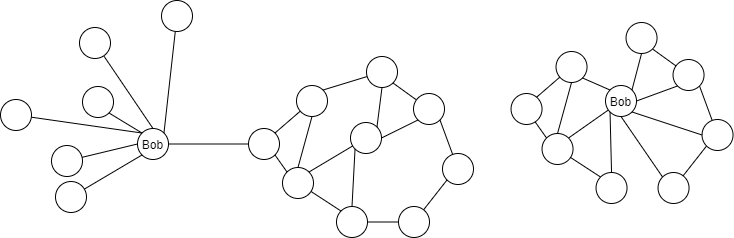

As you can see, Bob although having the same number of connections in both of the networks. Bob is located to more center of right network.

#### Betweennes centrality
- Betweenness centrality is important in many cases in network analysis. As above exmaple tells, a higher degree centrality will not always yield to higher betweenness centrality. Betweenness centrality is an important metric, as it discovers nodes connecting many dispatched group of nodes to one another.

- For betweenness centrality, **higher values** mean that the node is connecting higher number of nodes to one another. In co-authorship networks this could be the fact that authors having higher betweenness centrality have diverse set of interests and possibly interacts and experiments with diverse set of fields. These people are very important in fight against covid19.

In [ ]:
#from IPython.display import Image
#Image(filename='../pics/betwennessBob.png', width=800, height=800)

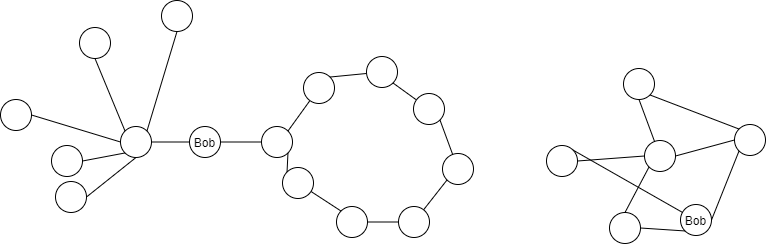

As you can see, Bob although having less number of connections, Bob is connecting two dispatched group of nodes

In [ ]:
authors['degree'] = authors['author_id'].apply(lambda l: deg_measure[a_int_id.get(l)])
authors['degree_cent'] = authors['author_id'].apply(lambda l: cent_measure[a_int_id.get(l)])
authors['degree_bet'] = authors['author_id'].apply(lambda l: bet_measure.get(a_int_id.get(l)))
authors_df = pd.merge(authors_df,authors[['author_id','degree','degree_cent','degree_bet']],on=['author_id'],how='left')

In [ ]:
plt.style.use('seaborn-pastel')
degree_sort = authors.sort_values(by=['degree'],ascending=False)[0:10][['author_name','degree']]
degree_sort = degree_sort.set_index('author_name')
ax = degree_sort.plot.barh(rot=0,figsize=(18,5))
ax.invert_yaxis()  # labels read top-to-bottom
plt.ylabel("degree")
#plt.style.use('fivethirtyeight')



In [ ]:
degree_sort = authors.sort_values(by=['degree_cent'],ascending=False)[0:10][['author_name','degree_cent']]
degree_sort = degree_sort.set_index('author_name')
ax = degree_sort.plot.barh(rot=0,figsize=(18,5))
ax.invert_yaxis()  # labels read top-to-bottom
plt.ylabel("degree_centrality")
#plt.style.use('bmh')


In [ ]:
degree_sort = authors.sort_values(by=['degree_bet'],ascending=False)[0:10][['author_name','degree_bet']]
degree_sort = degree_sort.set_index('author_name')
ax = degree_sort.plot.barh(rot=0,figsize=(18,5))
ax.invert_yaxis()  # labels read top-to-bottom
plt.ylabel("degree_betwenness")

- Above graph lists the highest 10 rankings of scholars in terms of centrality measures in overall network. The reason of different rankings in betweeness degree is possibly an explanation to existence of different research groups, but a scholar hierarchy between authors.
- Another insight is that authors with both high betweennness and degree centrality should be at the very heart of the fight against covid19. Not only these authors contributed to their research areas but also they connect dispatched groups. 

#### Freeman’s general formula for centralization


In [ ]:
#Image(filename='../pics/networkCentralization.png', width=400, height=400)

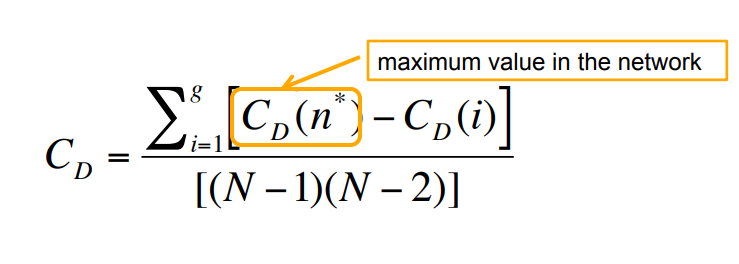

In [ ]:
sum(max(authors['degree'])-authors['degree'])/((len(authors)-1)*(len(authors)-2))

Centralization is distributed across nodes, which is good 

#### Network Visualization
Co-author network, where nodes represent authors and edges represents if the connection between authors. 
- For now, the size of the node is proportional to the co-authorships of the author. 
- Colors represent the class identified with the author (the research interests, topics) in the network. 
- Hovering over the nodes displays information about the author. 

In [ ]:
print(G.number_of_edges(), G.number_of_nodes(), nx.density(G)) 


In [ ]:
author_classes = dict(zip(authors_df.author_id, authors_df.label))

Since the network is very sparse, we filter authors contributing to a threshold number of papers in the network. This allows network analysis to be more informative. 

In [ ]:
cls_names ={0: 'label1', 1: 'label2', 2: 'label3', 3: 'label4', 4: 'label5', 5:'label6',6:'label7',7:'label8',8:'label9',9:'label10'}

filterAuthors = dict(zip(author_papers['author_id'].value_counts().keys(),author_papers['author_id'].value_counts().values))
filterAuthors = [authorId for authorId,paperCount in filterAuthors.items() if paperCount>2]

#subnetwork
G1 = G.subgraph([a_int_id[i] for i in filterAuthors])
print(G1.number_of_edges(), G1.number_of_nodes())

In [ ]:
#import sys
#!{sys.executable} -m pip install pygraphviz 
"""from IPython.utils import io
with io.capture_output() as captured:
    !pip install pygraphviz

from networkx.drawing.nx_agraph import graphviz_layout
pos_nodes = graphviz_layout(G)

"""
node_pos= nx.spring_layout(G1, iterations=50)


In [ ]:
from tqdm import tqdm 

groups=[]
for node in tqdm(G1.nodes()):
    groups.append(author_classes[int_a_id[node]])
    
group_colors = {0:'grey', 1:'green', 2:'red', 3:'blue',4:'mediumpurple',5:'lightsalmon',6:'orange',7:'darkmagenta',8:'maroon',9:'aqua'}
##match authornames with authorids
a_id_name = dict(zip(authors.author_id, authors.author_name))

In [ ]:
#import sys
#!{sys.executable} -m pip install plotly 
from IPython.utils import io
with io.capture_output() as captured:
    !pip install plotly

In [ ]:
import plotly.offline as plotly # Interactive plotting library
from plotly.graph_objs import *
from plotly import tools # Plotly's tools, such as for making figures/subplots

# Initialize plotly in offline mode
plotly.init_notebook_mode(connected=True)

edge_trace = Scatter(
    x=[],
    y=[],
    line=Line(width=1.5,color='#888'),
    hoverinfo='none',
    mode='lines')
x_list = []
y_list = []
for edge in tqdm(G1.edges(data=True)):
    
    x0, y0 = node_pos[edge[0]]
    x1, y1 = node_pos[edge[1]]
    x_list = list(edge_trace['x'])
    x_list += [x0, x1]
    edge_trace['x'] = tuple(x_list)
    y_list = list(edge_trace['y'])
    y_list += [y0, y1]
    edge_trace['y'] = tuple(y_list)

print("done with edges")


In [ ]:
node_trace = Scatter(
    x=[],
    y=[],
    text=[],
    mode='markers',
    hoverinfo='text',
    marker=Marker(
        showscale=True,
        colorscale='Jet',
        color=groups,
        size=[],
        colorbar=dict(
            title='Class',
            tickvals = [i for i in range(10)],
            ticktext = [cls_names[i] for i in range(10)],
            ticks = 'outside'
        ),
        line=dict(width=1)))
x_list = []
y_list = []
for node in tqdm(G1.nodes()):
    x, y = node_pos[node]#G.node[node]['pos']
    x_list = list(node_trace['x'])
    x_list += [x]
    y_list = list(node_trace['y'])
    y_list += [y]
    node_trace['x'] = tuple(x_list)
    node_trace['y'] = tuple(y_list)

In [ ]:
node_deg = G1.degree()
node_trace['marker']['size'] =[]
node_trace['marker']['color'] =[]
node_trace['text'] =[]
max_degree = max([node[1] for node in node_deg])
marker_size_list = []
marker_text_list = []
marker_color_list = []
for node in tqdm(G1.nodes()):
    marker_size_list = list(node_trace['marker']['size'])
    marker_size_list += [50*(node_deg[node])/max_degree]
    node_trace['marker']['size'] = tuple(marker_size_list)
    name = a_id_name.get(int_a_id[node])
    node_info = '# of connections: %s <br />AuthorName: %s <br />AuthorID: %s <br />Label: %s'%(str(node_deg[node]), str(name),str(int_a_id[node]),
                                                                                               str(author_classes[int_a_id[node]]))
    marker_text_list = list(node_trace['text'])
    marker_text_list += [node_info]
    node_trace['text'] = tuple(marker_text_list)
    marker_color_list = list(node_trace['marker']['color'])
    marker_color_list += [author_classes[int_a_id[node]]]
    node_trace['marker']['color'] = tuple(marker_color_list)

In [ ]:
fig = Figure(data=Data([edge_trace, node_trace]),
             layout=Layout(
                title='<br>Collaboration Network',
                titlefont=dict(size=16),
                showlegend=False,
                hovermode='closest',
                margin=dict(b=10,l=15,r=5,t=40),
                xaxis=XAxis(autorange=True, showgrid=False, zeroline=False, showticklabels=False),
                yaxis=YAxis(autorange=True, showgrid=False, zeroline=False, showticklabels=False)))

plotly.iplot(fig, filename='collaboration_network_vis')

This network looks promosing. As it definitely identifies small groups of networks as well as the big actors. Authors that could be responding with right answers and should in my naive opinion be much more in front of the fight against disease include: 
<li><a href="http://med.sustc.edu.cn/staff/view/id-73.html?locale=en_US">Professor Zheng Zhang</a></li>
<li><a href="http://med.sustech.edu.cn/staff/view/id-72.html?locale=en_US">Professor Liu Lei</a></li>
<li><a href="http://www.csu.edu.cn/organization/academy/yanjiusuo/mirc/name_ww.htm">Professor Wei Wang</a></li>


There exists diverse research groups of different size and interest. These research groups can be seen as clusters of same color in the co-network analysis. Authors having same color indicates that their research interests are similar to each other. Let's observe this on a particular example.

In [ ]:
df[df['sha'] == "e0f76974abe7c6d61b7ddea1c46fff36831d34a4"][[column for column in df.columns.values if 'topic' in column]]

In [ ]:
df[(df['sha'] == "e0f76974abe7c6d61b7ddea1c46fff36831d34a4") | (df['sha'] == "d548934676e1a7e52a001348244b52760e5a2ad4") |
  (df['sha'] == "d4514afa97f2fcbcecac303c4975854d92dda228")][[column for column in df.columns.values if 'topic' in column]].describe()

Example shows one of the papers research group colored dark blue with label 1 has written. The papers of this particular research group have high values in columns topic 13 topic 14. These topics are about antivirus and vaccines. This shows that our topic modelling is able to summarize the interests of the research groups and authors in particular. But this analysis needs more evaluation. The point was that reserch groups are indeed visible in the network with colors indicating their research areas and interests.

An interesting property of the co-authorship network is that the node's sizes are directly proportional to the respective research group size. This although makes research groups more visible in the network, metrics other than degree can be used to rescale nodes. Betweenness, closeness, custom degree metrics are some of the choices here.

In [ ]:
import matplotlib.pyplot as plt
plt.figure(3,figsize=(12,12)) 
nx.draw(G1, with_labels=False, node_size = 2, node_color = 'lightblue') 

**Future work include**:
<li>Filtering options should be added in order to filter out co-network and focus on particular groups</li>
<li><a href="https://ieeexplore.ieee.org/stamp/stamp.jsp?arnumber=6297585">Evaluate different layouts using different network visualization techniques</a></li>
<li>Better evaluate topic modelling and tagging procedures</li>
<li>Augment dataset with citation counts, etc</li>
<li>Include more network metrics and investigate their relation with co-author network analysis in greater depth</li>
<li>Answer task related questions considering co-authorship network and their research interests(labels from clustering) so that more refined answers could be found</li>
<li>Make the analysis live so that it is easy to detect recent changes in the network</li>